In [9]:
# deep learning 
import tensorflow.compat.v1 as tf #YD: add.compat.v1 to invert to earlier version
# tf.disable_v2_behavior() #YD
tf.compat.v1.disable_eager_execution()
import keras.backend as K
from keras.layers import GaussianNoise, Dense, Activation, Input
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment as linear_assignment
# general tools
import os
import numpy as np
from tqdm import tqdm
from preprocess import *
from io import *

# os.chdir("..")
# check current working directory
print("Current Working Directory: ", os.getcwd())

# list files in the current directory
print("Files in Current Directory: ", os.listdir())

# check if eager executation is enabled
print("Eager execution: {}".format(tf.executing_eagerly()))

Current Working Directory:  /Users/yufeideng/Documents/GitHub/bis687-project
Files in Current Directory:  ['.DS_Store', 'pytest.ini', 'LICENSE', 'requirements.txt', 'sc-env', 'demo.ipynb', 'reproducibility', 'docs', 'README.md', 'results', 'proposal', 'iterative', '.gitignore', 'scripts', 'dca', '.git', 'LICENSE.txt', 'data', 'scDMFK', 'clustering.ipynb']
Eager execution: False


In [3]:
## Define activation and loss functions (neglected ZINB and MSE methods)

MeanAct = lambda x: tf.clip_by_value(x, 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

def multinomial(y_true, y_pred):
    loss = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
    return loss

def _nan2zero(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)


In [35]:
##Define model architecture and training steps

class scDMFK(object):
    def __init__(self, output_dir, input_size, dims=[64,32], cluster_num=1, alpha=0.001, sigma=1, theta=1, learning_rate=0.0001, noise_sd=1.5, init='glorot_uniform', act='relu', adaptative = True, model = "multinomial", mode = "indirect"):
        self.output_dir = output_dir #Added for saving output
        self.input_size = input_size #Added for initializing tensor for input
        self.output_size = self.input_size #for initializing denoised output
        self.dims = dims
        self.cluster_num = cluster_num
        self.alpha = alpha
        self.sigma = sigma
        self.theta = theta
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act
        self.adaptative = adaptative
        self.model = model
        self.mode = mode
        
        self.n_stacks = len(self.dims) - 1
        # input layer
        self.x = tf.placeholder(dtype=tf.float32, shape=(None, self.input_size))
        self.x_count = tf.placeholder(dtype=tf.float32, shape=(None, self.input_size))
        self.sf_layer = tf.placeholder(dtype=tf.float32, shape=(None, 1))
        
        self.h = self.x
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
        
        for i in range(self.n_stacks - 1):# encoder layeres
            self.h = Dense(units=self.dims[i + 1], kernel_initializer=self.init, name='encoder_%d' % i)(self.h)
            self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
            self.h = Activation(self.act)(self.h)
        # latent layer --> for outputing latent representation
        self.latent = Dense(units=self.dims[-1], kernel_initializer=self.init, name='encoder_hidden')(self.h)  # hidden layer, features are extracted from here
        self.h = self.latent
        # decoder layers
        for i in range(self.n_stacks - 1, 0, -1):
            self.h = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init,
                        name='decoder_%d' % i)(self.h)
        # output layers
        if self.model == "multinomial":
            if mode == "indirect":
                self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
                ## self.output: this one is the expected count Vij for denoising purpose!!
                self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
                self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
                self.P = tf.transpose(tf.transpose(self.pi * self.output) / tf.reduce_sum(self.pi * self.output, axis=1))
                self.pre_loss = multinomial(self.x_count, self.P)
            else:
                self.P = Dense(units=self.output_size, activation=tf.nn.softmax, kernel_initializer=self.init, name='pi')(self.h)
                self.pre_loss = multinomial(self.x_count, self.P)
        elif self.model == "ZINB":
            self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
            self.disp = Dense(units=self.output_size, activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h)
            self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
            self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
            self.pre_loss = ZINB(self.pi, self.disp, self.x_count, self.output, ridge_lambda=1.0)
        elif self.model == "weight mse":
            self.recon_x = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            self.weight_mse = weight_mse(self.x_count, self.x, self.recon_x)
        else:
            self.recon_x = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            self.mask_mse = mask_mse(self.x_count, self.x, self.recon_x)

        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.pretrain_op = self.optimizer.minimize(self.pre_loss)


    def write(self, adata, colnames=None, rownames=None):  #YD added
        colnames = adata.var_names if colnames is None else colnames
        rownames = adata.obs_names if rownames is None else rownames 

        data_path = 'data/' + self.output_dir + '/'
        os.makedirs(data_path, exist_ok=True)
        print('scDMFK: Saving output(s) to %s' % data_path)
        write_text_matrix(self.output_mat,
                          os.path.join(data_path, 'mean-scdm.csv'),
                          rownames=rownames, colnames=colnames, transpose=False)
        # write_text_matrix(self.latent_repre,
        #                   os.path.join(data_path, 'latent-scdm.csv'),
        #                   rownames=rownames, transpose=False)


    def pretrain(self, X, count_X, size_factor, batch_size=128, pretrain_epoch=300, gpu_option='0'):
        print("Begin the pretraining...")
        init = tf.group(tf.global_variables_initializer(),
                        tf.local_variables_initializer())
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option
        config_ = tf.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        self.sess = tf.Session(config=config_)
        self.sess.run(init)
        
        # initialize output matrices
        self.latent_repre = np.zeros((X.shape[0], self.dims[-1]))
        self.output_mat = np.zeros((X.shape[0], X.shape[1])) # has dimension=input count matrix
        
        pre_index = 0
        for ite in range(pretrain_epoch):
            while True:
                if (pre_index + 1) * batch_size > X.shape[0]:
                    last_index = np.array(
                        list(range(pre_index * batch_size, X.shape[0])) + 
                        list(range((pre_index + 1) * batch_size - X.shape[0]))
                        )
                    _, pre_loss, latent, output = self.sess.run(
                        [self.pretrain_op, self.pre_loss, self.latent, self.output],
                        feed_dict={
                            self.sf_layer: size_factor[last_index],
                            self.x: X[last_index],
                            self.x_count: count_X[last_index]})
                    self.latent_repre[last_index] = latent
                    self.output_mat[last_index] = output #appending to denoised output
                    pre_index = 0
                    break
                else:
                    _, pre_loss, latent, output = self.sess.run(
                        [self.pretrain_op, self.pre_loss, self.latent, self.output],
                        feed_dict={
                            self.sf_layer: size_factor[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)],
                            self.x: X[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)],
                            self.x_count: count_X[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)]})
                    self.latent_repre[(pre_index * batch_size):((pre_index + 1) * batch_size)] = latent
                    
                    #appending to denoised output
                    self.output_mat[(pre_index * batch_size):((pre_index + 1) * batch_size)] = output
                    pre_index += 1
                
        self.sess.close()
        print('Training done!')
        return self.output_mat

In [9]:
# modified 预处理: 默认highly_genes=None 即对所有genes进行降噪
def normalize(adata, highly_genes = None, size_factors=True, normalize_input=True, logtrans_input=True):
    sc.pp.filter_genes(adata, min_counts=1)
    sc.pp.filter_cells(adata, min_counts=1)
    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    highly_genes = adata.n_vars if None else highly_genes
    subset = highly_genes is not None
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=highly_genes, subset=subset)

    return adata

### Simulated data

In [39]:
# 读取模拟数据
dataname = "group10_dropout5/counts.tsv"
output_dir = None
transpose = True
highly_genes = None
adata = prepro(dataname, transpose=transpose)
adata = normalize(adata, highly_genes=highly_genes)

X = adata.X.astype(np.float32)
count_X = np.ceil(X).astype(np.int)

input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

# print原始模拟数据 （非真实值）
raw = pd.DataFrame(adata.raw.X, columns=adata.raw.var_names)[adata.var_names]
raw

Successfully preprocessed 200 genes and 2000 cells


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:237: RuntimeWarning: invalid value encountered in true_divide
  df['dispersions_norm'] = (


,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
0,0.0,0.0,0.0,496.0,0.0,280.0,0.0,56.0,0.0,0.0,...,0.0,224.0,925.0,0.0,0.0,0.0,383.0,1262.0,0.0,0.0
1,0.0,0.0,0.0,312.0,0.0,0.0,276.0,0.0,210.0,0.0,...,0.0,194.0,0.0,0.0,0.0,160.0,449.0,0.0,14.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.0,0.0,...,22.0,0.0,424.0,0.0,0.0,126.0,590.0,1547.0,0.0,0.0
3,0.0,56.0,0.0,0.0,0.0,249.0,0.0,0.0,0.0,0.0,...,0.0,235.0,677.0,0.0,0.0,144.0,0.0,1279.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,156.0,0.0,0.0,0.0,0.0,...,0.0,149.0,397.0,0.0,0.0,0.0,347.0,1030.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,114.0,0.0,96.0,0.0,...,0.0,120.0,309.0,0.0,0.0,0.0,201.0,982.0,0.0,0.0
1996,0.0,71.0,27.0,299.0,0.0,0.0,221.0,0.0,183.0,0.0,...,40.0,163.0,500.0,0.0,0.0,105.0,245.0,1230.0,0.0,102.0
1997,23.0,0.0,0.0,291.0,0.0,194.0,0.0,0.0,121.0,16.0,...,0.0,0.0,504.0,0.0,0.0,90.0,322.0,994.0,0.0,74.0
1998,0.0,51.0,0.0,310.0,0.0,204.0,213.0,0.0,0.0,0.0,...,0.0,186.0,452.0,0.0,0.0,0.0,282.0,1075.0,0.0,0.0


scDMFK Denoising...

In [40]:
model = scDMFK(output_dir, input_size, dims=[32,16])
denoise = model.pretrain(X, count_X, size_factor, batch_size=128, pretrain_epoch=100, gpu_option='0')
pd.DataFrame(denoise, index=adata.obs_names, columns=adata.var_names)

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
Cell1,0.000015,0.000015,0.000015,0.390634,0.052240,0.328588,0.548201,0.000015,0.000015,0.000015,...,0.000015,0.000015,0.000015,1.251136,0.000015,0.878478,1.334375,0.386499,0.000015,0.000015
Cell2,0.932168,0.419320,0.000011,0.086794,0.316074,0.237539,0.000011,0.233598,0.000011,0.000011,...,0.000011,0.000967,0.000011,0.000011,0.000011,0.164023,0.000011,0.000011,0.768135,0.415614
Cell3,0.299736,0.000012,0.000012,0.000012,0.663274,0.000012,0.000012,0.975123,0.605680,0.520660,...,0.520569,0.000012,0.273055,0.000012,0.755236,0.000012,0.347250,0.386378,0.106847,0.056431
Cell4,0.327059,0.324387,0.426296,0.089033,0.254067,0.000011,0.000011,0.359803,0.371885,0.000011,...,0.000011,0.195785,0.000011,0.333859,0.000011,0.416106,0.000011,0.000011,0.239475,0.099495
Cell5,0.000008,0.000008,0.000008,0.000008,0.549722,0.356136,0.000008,0.000008,0.000008,0.000008,...,0.000008,0.293906,0.000008,0.370122,0.000008,0.000008,0.197894,0.000008,0.000008,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell1996,0.063960,0.161080,0.113203,0.000006,0.000006,0.504407,0.708444,0.000006,0.323471,0.000006,...,0.435079,0.000006,0.670631,0.173746,0.000006,0.000006,0.000006,0.005247,0.176893,0.000006
Cell1997,0.131505,0.000010,0.000010,0.452144,0.654483,0.000010,0.000010,0.220487,0.000010,0.000010,...,0.226242,0.548948,0.676388,0.000010,0.000010,0.070524,0.000010,0.000010,0.586920,0.281312
Cell1998,0.171732,0.000010,0.615227,0.144111,0.019855,0.000010,0.000010,0.521837,0.714721,0.000010,...,0.000010,0.000010,0.109629,0.000010,0.000010,0.393024,0.000010,0.000010,0.000010,0.000010
Cell1999,0.044913,0.000010,0.175508,0.519077,0.000010,0.000010,0.000010,0.000010,0.246190,1.150515,...,0.000010,1.220432,0.859404,0.285692,0.396325,0.000010,0.000010,0.553706,0.668841,0.000010


## Analysis: Clustering

In [61]:
from scDMFK.io import get_embedding, draw_umap

Clustering with raw simulated data

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


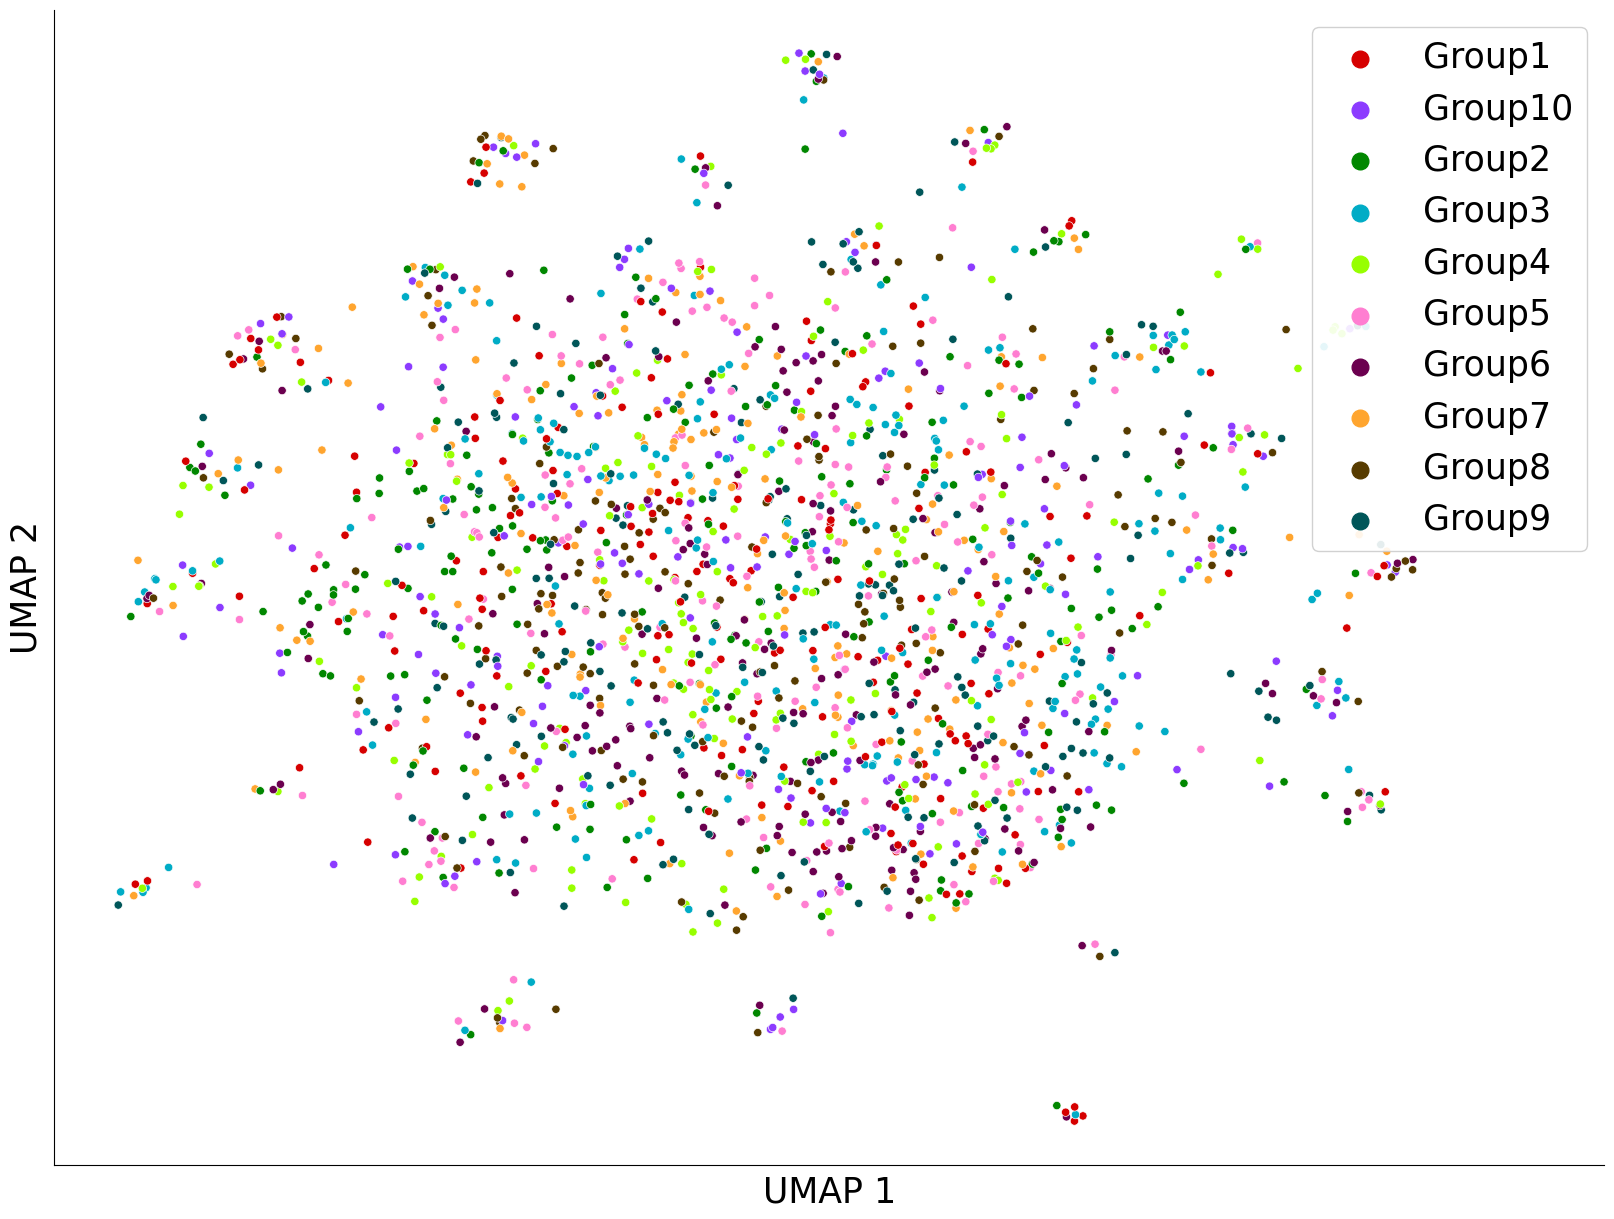

In [48]:
sim_label= pd.read_csv('data/group10_dropout5/info_cellinfo.tsv', sep='\t')['Group']
## raw data
sim_emb = get_embedding(raw)
draw_umap(sim_emb, sim_label)

Clustering with scDMFK denoised (?) data

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


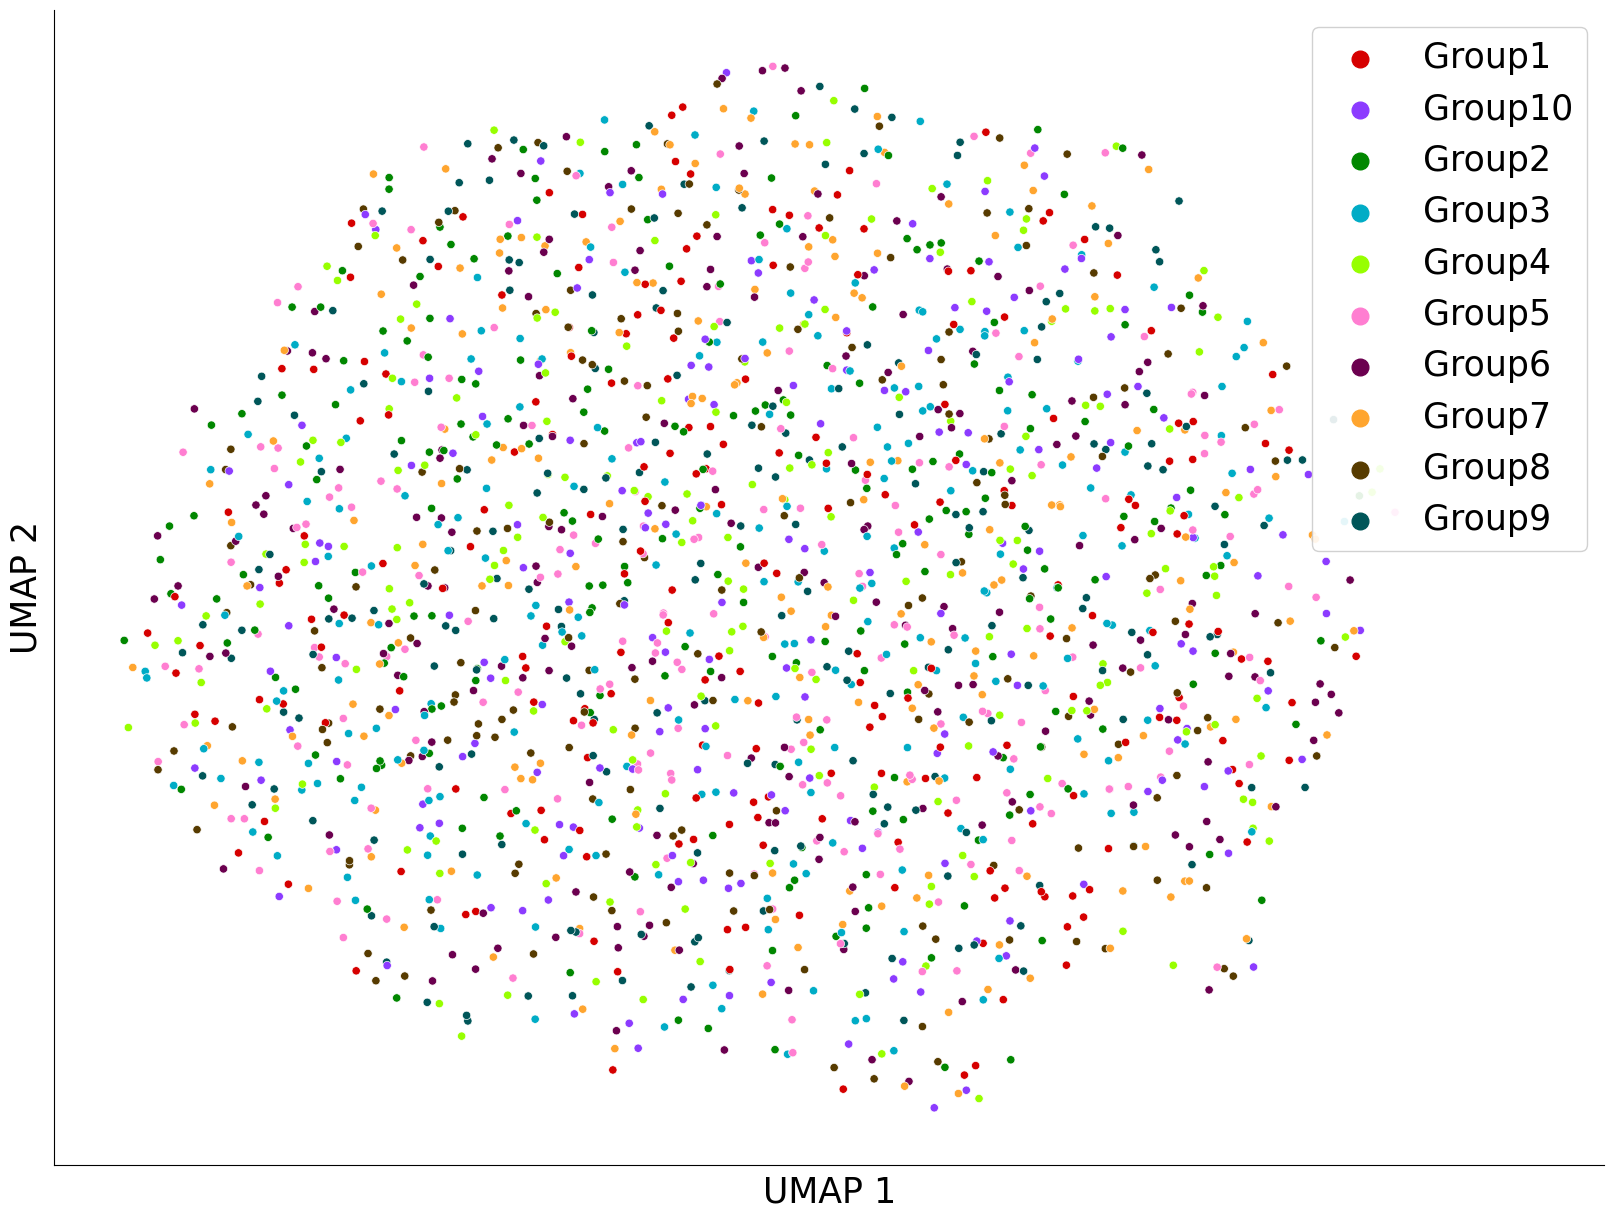

In [47]:
sim_scdm_emb = get_embedding(denoise)
draw_umap(sim_scdm_emb, sim_label)

#### DCA results

In [63]:
!python -m dca.__main__ data/group10_dropout5/counts.tsv results/group10_dropout5/ 

Using TensorFlow backend.

2024-04-20 13:06:10,035 [WARNING] From /Users/yufeideng/Documents/GitHub/bis687-project/dca/train.py:105: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

2024-04-20 13:06:10.036574: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
dca: Successfully preprocessed 200 genes and 2000 cells.
2024-04-20 13:06:10.649467: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
coun

Clustering with DCA denoised data

In [64]:
sim_dca = pd.read_csv('results/group10_dropout5/mean.tsv', sep='\t', index_col=0)
sim_dca

,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,Cell10,...,Cell1991,Cell1992,Cell1993,Cell1994,Cell1995,Cell1996,Cell1997,Cell1998,Cell1999,Cell2000
Gene1,3.661232,2.715294,5.549321,4.026049,2.636076,3.718536,4.106007,2.118743,1.957288,5.457618,...,2.231921,1.711946,4.109773,10.146824,4.031391,3.676610,5.741601,5.230560,6.034132,1.421102
Gene2,30.949125,21.206753,20.455433,20.034708,9.409648,23.742647,16.501753,4.645788,7.091904,32.737095,...,10.043410,8.384529,14.873137,34.222015,13.874279,6.782467,16.912752,14.450267,14.102468,15.069413
Gene3,0.437875,1.178412,0.805057,1.809369,1.567174,1.165566,2.497094,0.197564,0.538678,0.428294,...,0.514327,1.548302,0.917513,0.319445,0.153601,0.200575,0.406133,1.336224,0.657988,0.446966
Gene4,464.260468,337.373260,325.962006,309.561584,248.114105,269.349579,319.835327,178.518448,209.789276,388.342224,...,292.574982,276.616791,259.178131,425.900391,303.454742,217.640930,275.600647,251.232254,273.215424,285.271271
Gene5,3.742484,2.626760,1.281094,3.811470,1.846036,1.981426,2.391545,1.571505,0.784448,2.345070,...,1.533118,1.442765,3.294640,4.986814,6.537007,1.626631,1.955098,2.027989,2.810319,0.657777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gene196,163.160248,70.465630,59.494709,38.758587,25.780212,45.900585,48.108856,18.511572,17.184090,57.714706,...,50.215256,41.878304,38.299213,86.582306,24.328943,23.449327,63.270737,38.602715,36.473396,72.462433
Gene197,538.556458,430.869568,445.577209,357.279083,294.746338,368.379883,317.146973,177.206421,291.058929,476.567719,...,254.077438,326.780182,268.176971,503.224091,335.209137,305.955261,336.167969,282.807648,320.469269,315.118988
Gene198,1809.347412,1276.316528,1311.912964,1219.574829,924.695740,972.218262,1210.039185,628.356445,873.790283,1261.099365,...,1070.015625,1037.201782,944.297241,1504.338867,988.153320,922.685425,1058.494141,977.130615,996.788147,1089.239136
Gene199,0.166265,0.360609,0.498598,1.098108,0.055692,0.410468,0.069059,0.013065,1.208467,0.044944,...,0.102723,0.797288,0.393971,0.826277,0.254574,0.313170,0.715771,0.076423,0.059349,0.038643


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


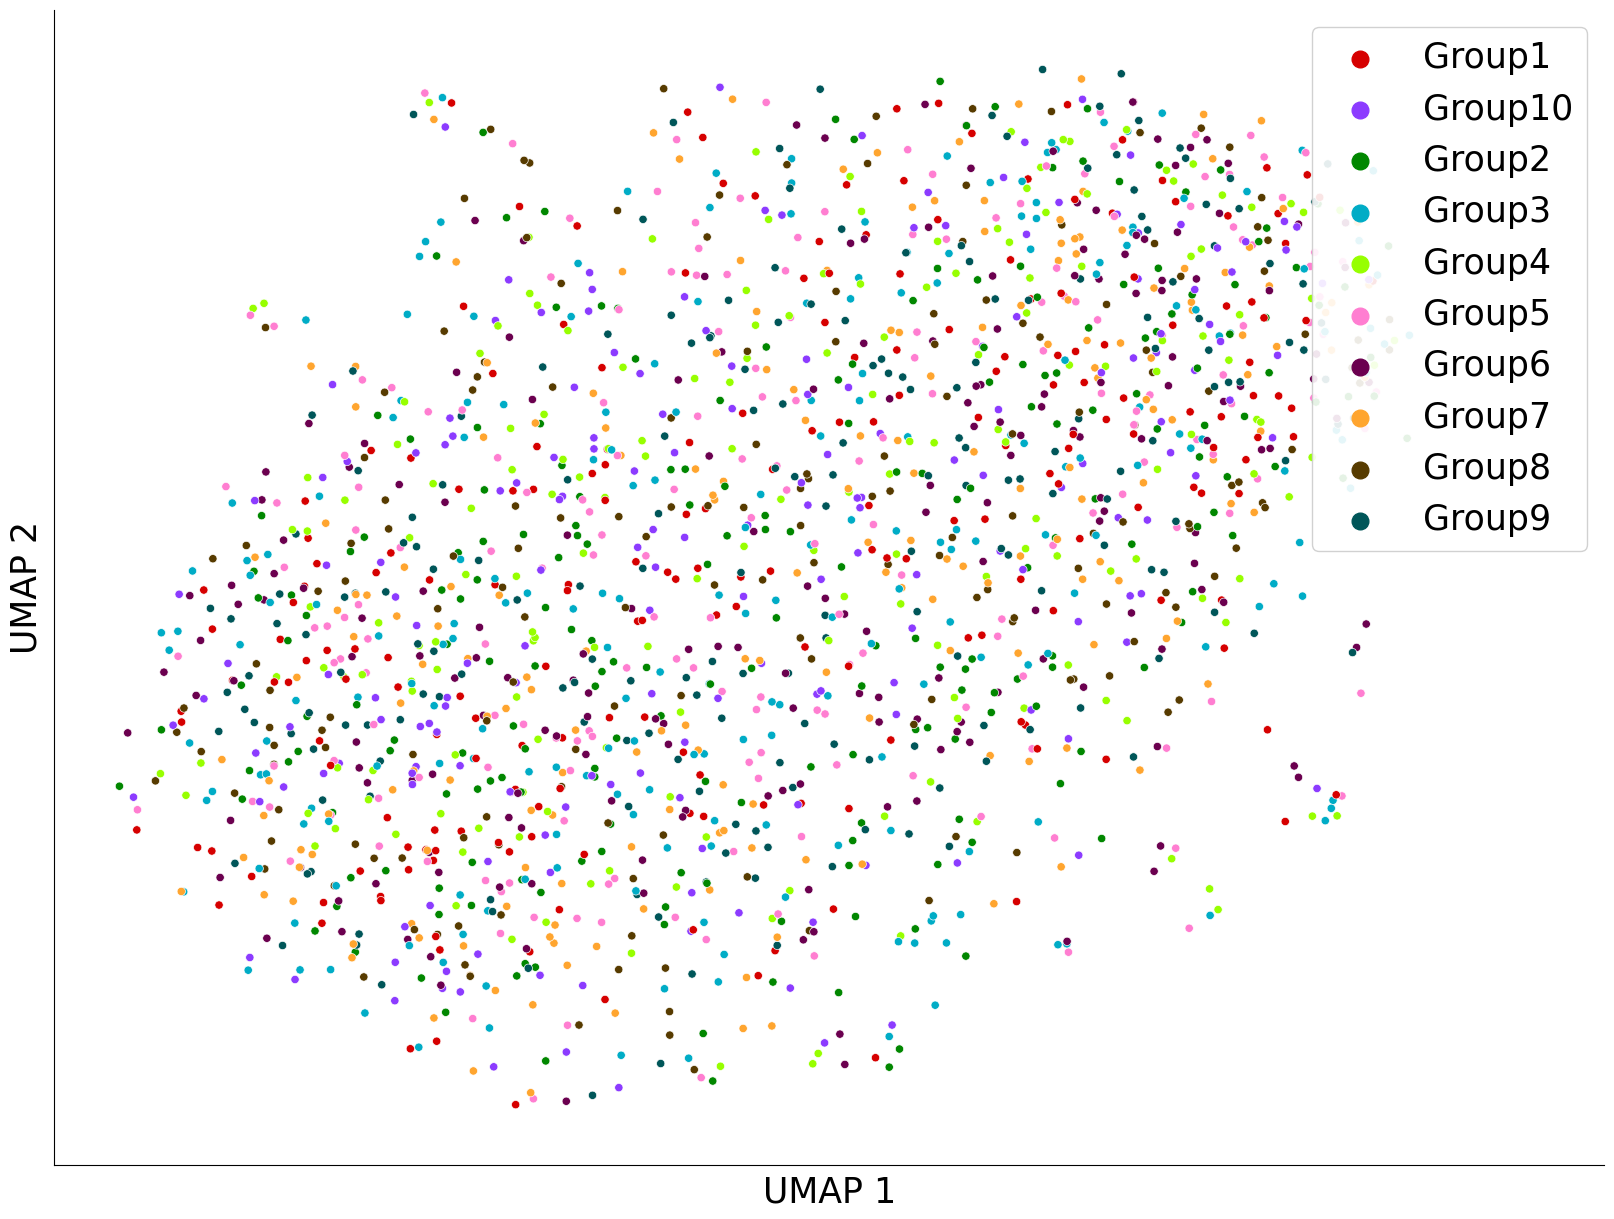

In [65]:
sim_dca_emb = get_embedding(sim_dca.T.values)
draw_umap(sim_dca_emb, sim_label)